# Experiment: Explore Water Management Strategies

Water Management is a complex topic. It involves many different actors, from the government to the private sector, and many different strategies, from water pricing to water reuse. In this experiment, we will explore the different strategies that countries have adopted to manage their water resources.

Especially, Waste Water Treatment and Reuse are important topics.

In [91]:
from src.aquastat_utils import *

# Import AQUASTAT
aquastat_df = get_aquastat()

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/Users/josef/Sync/Dokumente/SCHULE/Master/UT/Vorlesungen/Sem2/Data_Literacy/Paper/src/../dat/fao_aquastat.csv already exists.
Renaming countries ...


In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from tueplots import bundles

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 200})

# colormap for spatial plot
rb = LinearSegmentedColormap.from_list(
    "rb",
    [[0, 0, 153 / 255], [50 / 255, 150 / 255, 255 / 255], [1, 1, 1], [255 / 255, 102 / 255, 0], [153 / 255, 0, 0]],
    N=500
)


In [93]:
# Filter interesting variables
filter_for = ['waste', 'reuse', 'treatment']  # variables interesting for waste water treatment
filter_for = ['waste']

filtered_columns = [column for column in aquastat_df.columns if any([x in column.lower() for x in filter_for])]
filtered_columns

['% of area equipped for irrigation by direct use of  treated municipal wastewater',
 '% of area equipped for irrigation by direct use of non-treated municipal wastewater',
 'Area equipped for irrigation by direct use of non-treated municipal wastewater ',
 'Area equipped for irrigation by direct use of not treated municipal wastewater',
 'Area equipped for irrigation by direct use of treated municipal wastewater',
 'Capacity of the municipal wastewater treatment facilities',
 'Collected municipal wastewater',
 'Direct use of not treated municipal wastewater for irrigation purposes',
 'Direct use of treated municipal wastewater',
 'Direct use of treated municipal wastewater for irrigation purposes',
 'Not treated municipal wastewater',
 'Not treated municipal wastewater discharged (secondary water)',
 'Number of municipal wastewater treatment facilities',
 'Produced municipal wastewater',
 'Treated municipal wastewater',
 'Treated municipal wastewater discharged (secondary water)']

We now have a list of variables related to waste water and treatment. Let's explore them.

In [94]:
# Get for each country the number of municipal wastewater treatment facilities

# Create a new dataframe with only the columns we are interested in
interesting_var = 'Number of municipal wastewater treatment facilities'

waste_df = aquastat_df[['Country', 'Year', interesting_var]]
waste_df = waste_df.dropna()  # Drop rows with missing values
waste_df = waste_df.sort_values(by=interesting_var, ascending=False)  # Sort by number of facilities

waste_df

Variable,Country,Year,Number of municipal wastewater treatment facilities
10127,United States of America,2004,16583.0
10126,United States of America,2003,16501.0
10125,United States of America,2002,16419.0
10124,United States of America,2001,16337.0
10123,United States of America,2000,16255.0
...,...,...,...
9710,Turkmenistan,2015,1.0
9711,Turkmenistan,2016,1.0
9712,Turkmenistan,2017,1.0
9713,Turkmenistan,2018,1.0


The total number is not very interesting to us so lets look at facilities per capita.
We dont want to look at to small numbers so per 1000 people seems appropriate

In [95]:
'''Get facilities per n citizens'''
waste_df['Total population'] = aquastat_df['Total population']
n = 1000
waste_df[f'{interesting_var} per {n} citizens'] = (waste_df[interesting_var] / waste_df['Total population']) * n
waste_df

Variable,Country,Year,Number of municipal wastewater treatment facilities,Total population,Number of municipal wastewater treatment facilities per 1000 citizens
10127,United States of America,2004,16583.0,292354.658,56.722202
10126,United States of America,2003,16501.0,289815.562,56.936211
10125,United States of America,2002,16419.0,287279.318,57.153436
10124,United States of America,2001,16337.0,284607.993,57.401761
10123,United States of America,2000,16255.0,281710.909,57.700996
...,...,...,...,...,...
9710,Turkmenistan,2015,1.0,5565.287,0.179685
9711,Turkmenistan,2016,1.0,5662.368,0.176605
9712,Turkmenistan,2017,1.0,5757.667,0.173681
9713,Turkmenistan,2018,1.0,5850.901,0.170914


Plot the development of the number of facilities over time

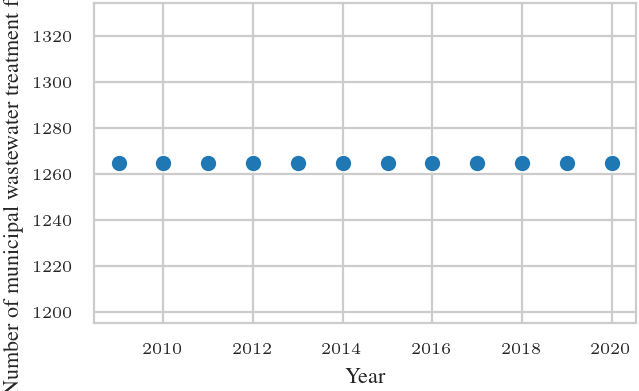

In [96]:
'''Just for testing'''
sns.scatterplot(data=waste_df[waste_df['Country'] == 'Canada'], x='Year',
                y='Number of municipal wastewater treatment facilities')
plt.show()

In [97]:
import numpy as np
import geopandas as gpd
from src.utils import to_dat_path, save_fig


def get_growth_rate(series, log_scale=False):
    """
    Calculate the relative growth rate of a series.
    !! It only looks at the first and last value in series !!
    :param series: series to calculate relative growth rate for.
    :return: Relative growth rate.
    """
    y = series.values
    rate = ((y[-1] - y[0]) / y[0]) * 100
    if log_scale:
        rate = np.log(rate)

    return rate


def plot_growth_rates(
        data: pd.DataFrame,
        variable: str,
        cmap: str = 'coolwarm_r',
        title_var: str = None,
        log_scale: bool = False
):
    """
    Plot relative growth rates for a variable on a world map.
    :param data: Dataframe containing countries, years and variables to plot.
    :param variable: Variable to plot.
    :param cmap: Preferred colormap for plotting. The Standard is 'coolwarm_r'.
    :param title_var: Preferred form of variable in title.
    :param log_scale: Whether to use a log scale for the growth rates.
    :return: Nothing
    """
    
    font_size = 15
    
    '''Get Rates'''
    # Pivot the DataFrame to have years as the index and countries as columns
    df_pivot = data.pivot(index='Year', columns='Country', values=variable).dropna()
    # Apply the function to calculate growth rate for each country
    rates = df_pivot.apply(get_growth_rate, log_scale=log_scale)
    # Convert the results to a DataFrame
    rates_df = rates.reset_index(name='Relative growth rate')

    # Get map
    world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
    # Join Data to map
    merged = world.set_index('SOVEREIGNT').join(rates_df.set_index('Country'))
    vmax = max(abs(merged['Relative growth rate'].min()), merged['Relative growth rate'].min())
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    merged.plot(
        column='Relative growth rate',
        ax=ax, legend=True,
        missing_kwds={"color": "darkgrey", "label": "No Data", },
        cmap=cmap, vmin=-vmax, vmax=vmax,
        legend_kwds={
            'label': "Relative Growth Rate",
            'orientation': "horizontal",
        }
    )
    
    # Set title
    years = df_pivot.index
    if title_var is None:
        title_var = f'Relative Growth of {variable} ({years.min()} - {years.max()})'
    ax.set_title(title_var, fontsize=20)
    
    # Change font sizes
    cbar = fig.axes[-1]
    cbar.set_xlabel('Relative Growth Rate', fontsize=font_size)
    for label in cbar.get_xticklabels():
        label.set_fontsize(15)

    # Create a custom legend patch for "No Data"
    no_data_patch = mpatches.Patch(color='darkgrey', label='No Data')
    plt.legend(handles=[no_data_patch], loc='upper right', fontsize=font_size)
    
    # Remove axis
    plt.axis('off')
    
    # Save figure
    plt.show()
    save_fig(fig, f'growth_rate_{variable.replace(" ", "_")}', 'water_management', experimental=True)

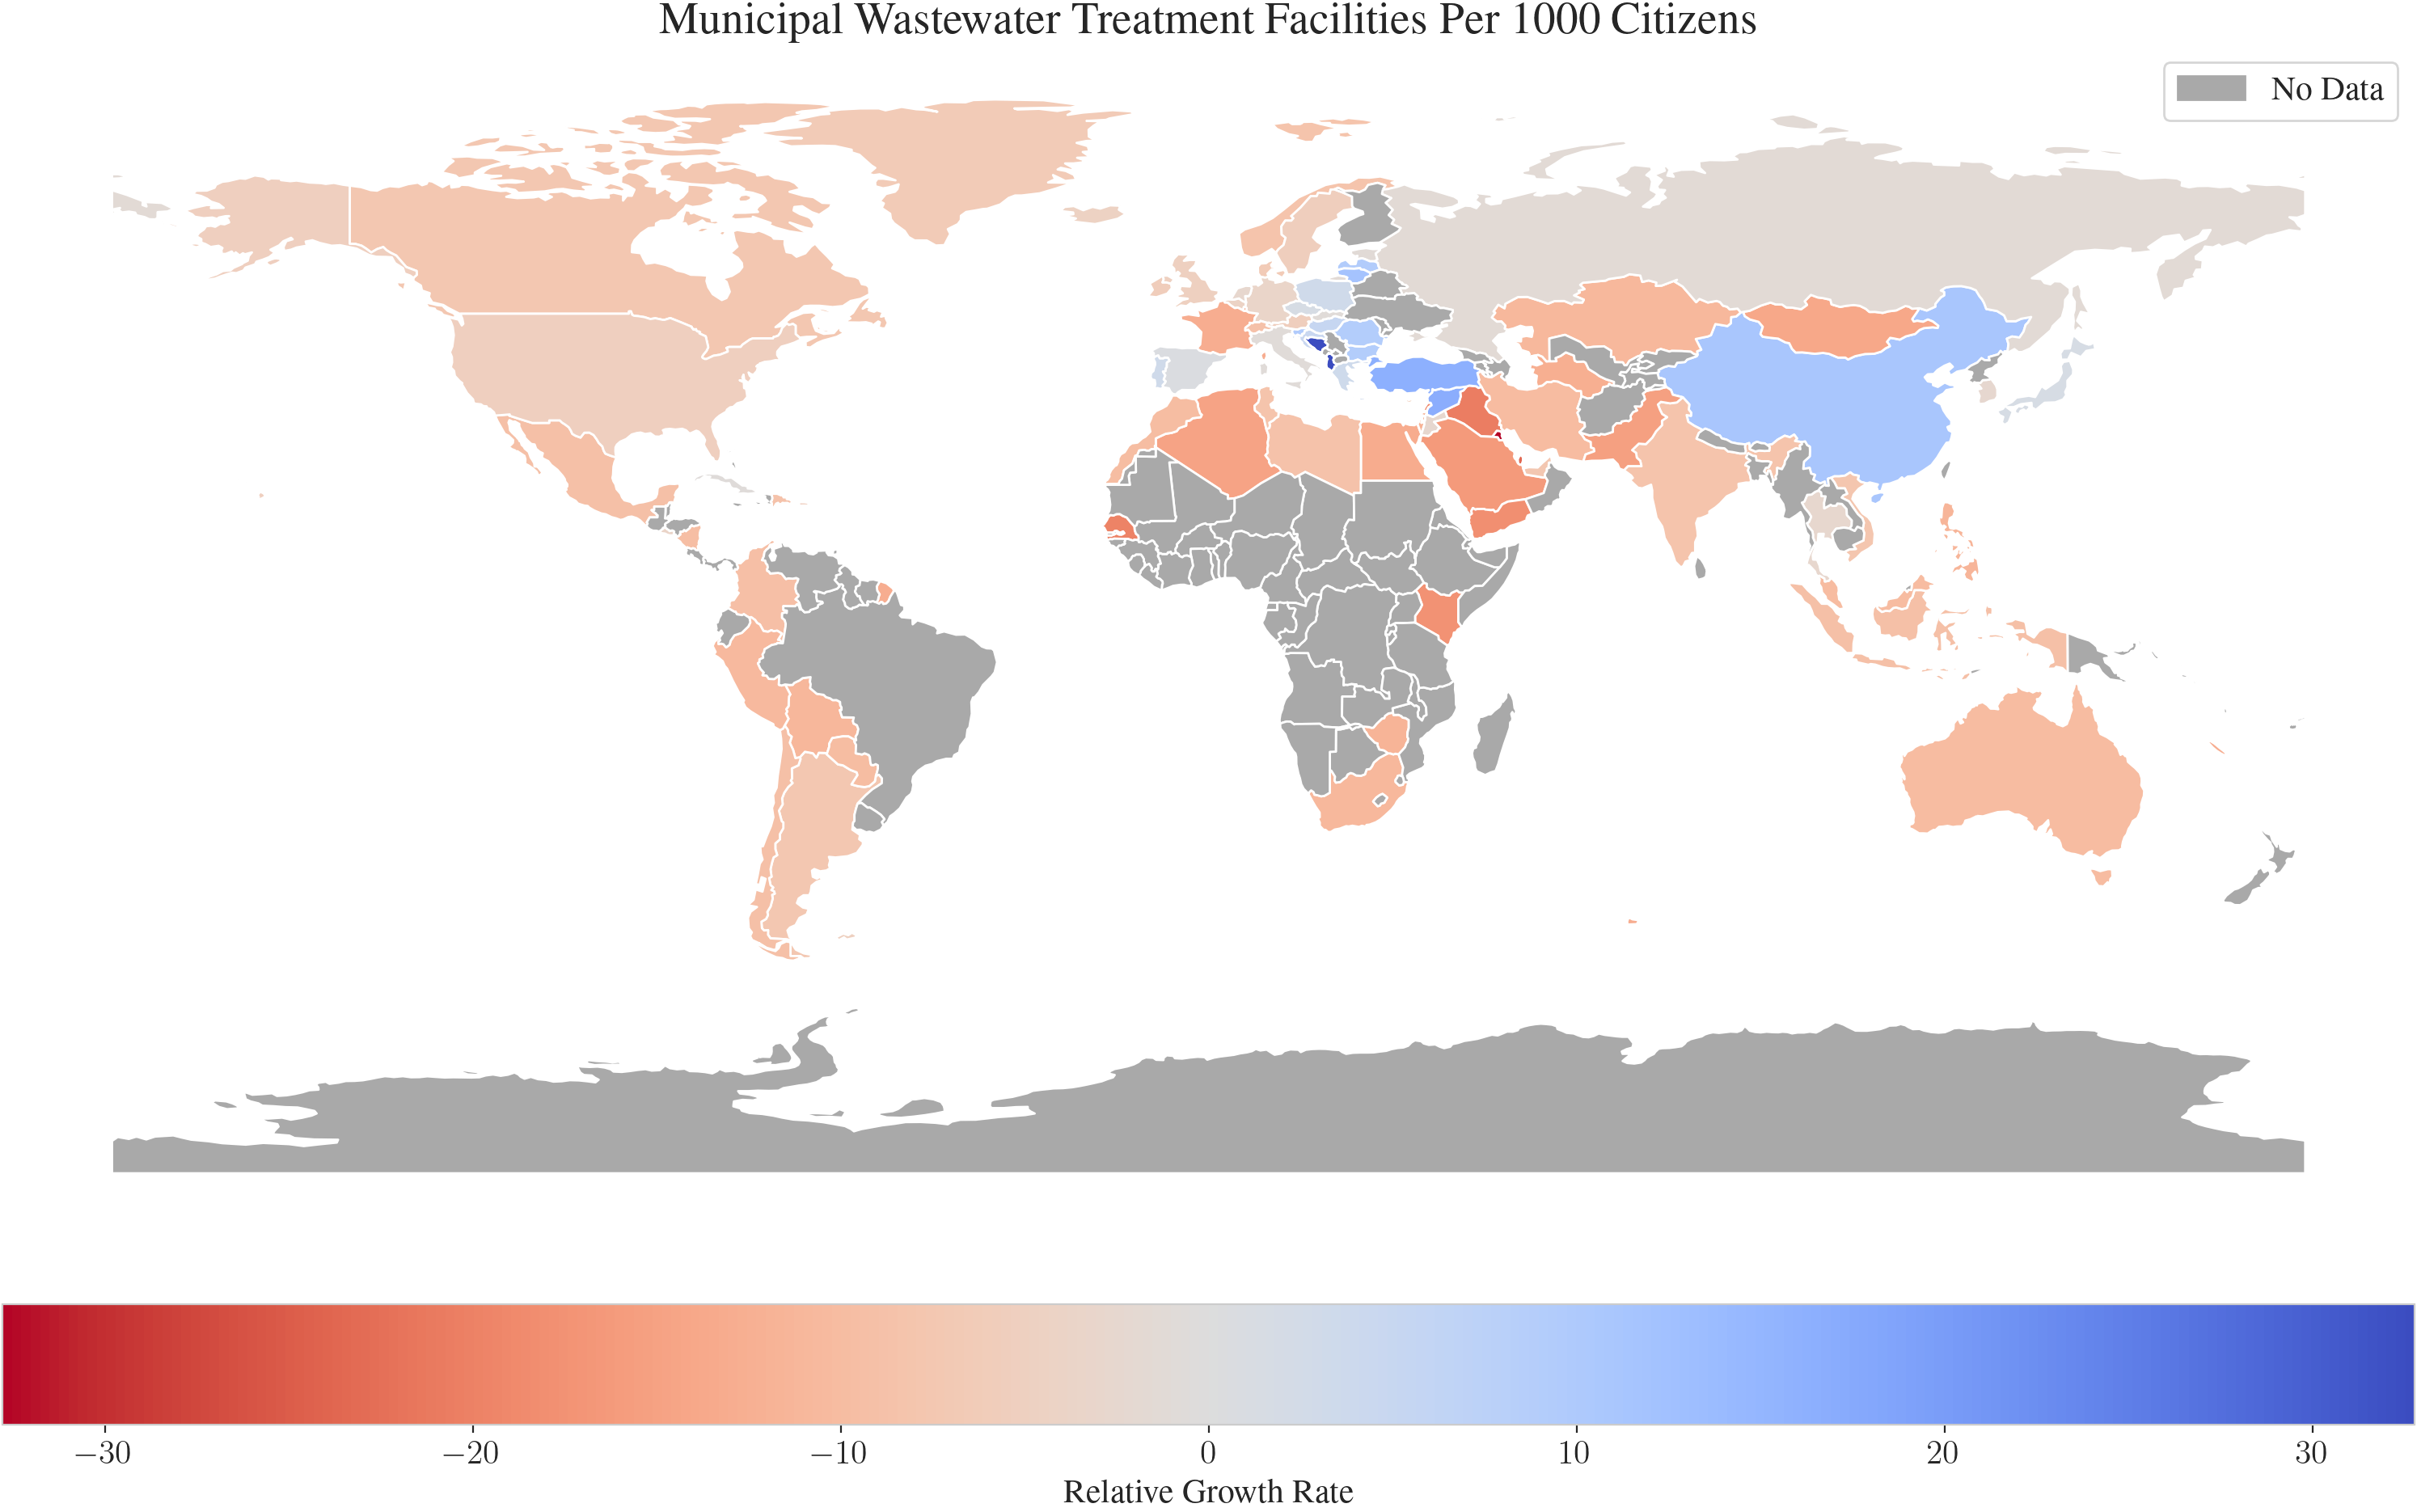

Saving figure to fig/water_management/fig_growth_rate_Number_of_municipal_wastewater_treatment_facilities_per_1000_citizens.pdf ... Done!


In [98]:
plot_growth_rates(
    waste_df,
    'Number of municipal wastewater treatment facilities per 1000 citizens',
    'coolwarm_r',
    'Municipal Wastewater Treatment Facilities Per 1000 Citizens'
)

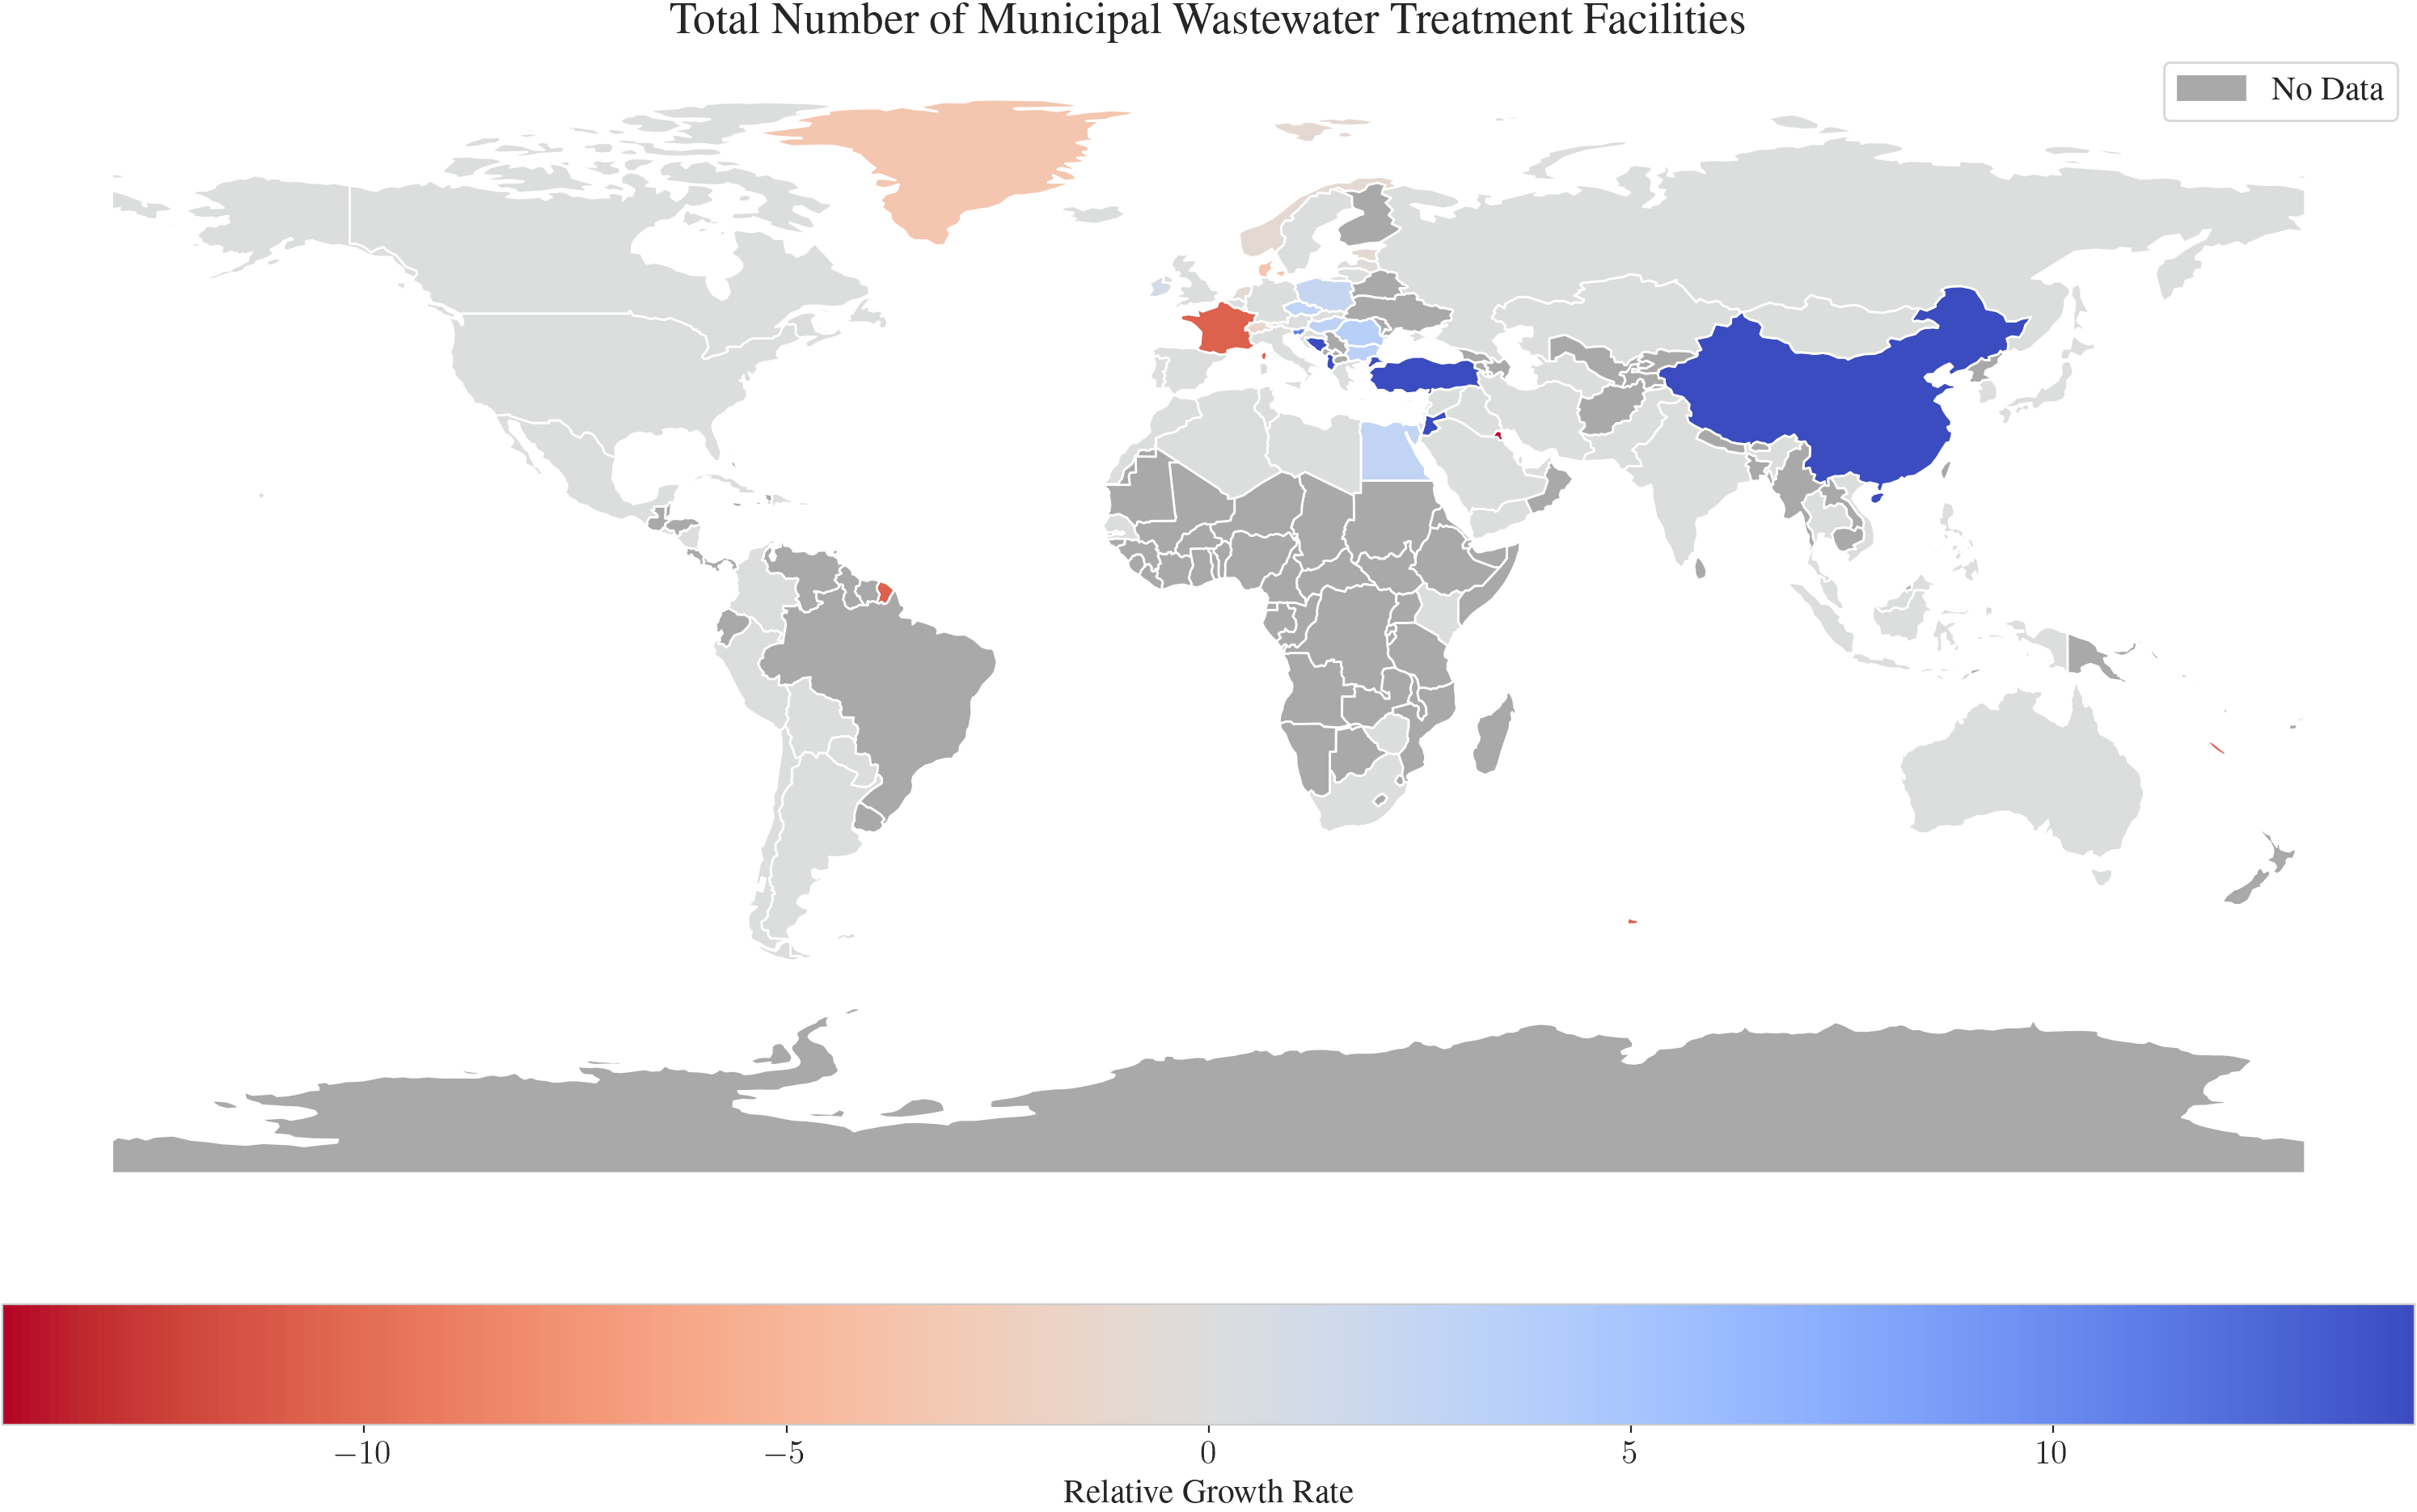

Saving figure to fig/water_management/fig_growth_rate_Number_of_municipal_wastewater_treatment_facilities.pdf ... Done!


In [99]:
plot_growth_rates(
    waste_df,
    'Number of municipal wastewater treatment facilities',
    'coolwarm_r',
    'Total Number of Municipal Wastewater Treatment Facilities'
)

It's odd to see that so many countries have a negative (redish) or a stagnant (dark grey) growth rate which means they stopped building facilities in the last years. Is there a reason for that? Maybe the water stress did not increase in these countries?

Water stress (SDG 6.4.2) is defined as the ratio of total water withdrawals to available renewable freshwater resources.

In [100]:
# Filter interesting variables
filter_for = ['stress']

filtered_columns = [column for column in aquastat_df.columns if any([x in column.lower() for x in filter_for])]
filtered_columns

['SDG 6.4.2. Water Stress']

In [101]:
# Plot the water quality for each country
# The countries that have a negative slope and a bad water quality, are the ones we are interested in

# Create a new dataframe with only the columns we are interested in
interesting_var = 'SDG 6.4.2. Water Stress'

stress_df = aquastat_df[['Country', 'Year', interesting_var]]
stress_df = stress_df.dropna()  # Drop rows with missing values
stress_df = stress_df.sort_values(by=interesting_var, ascending=False)  # Sort by number of facilities

stress_df

Variable,Country,Year,SDG 6.4.2. Water Stress
5044,Kuwait,2018,3850.500000
5046,Kuwait,2020,3850.500000
5045,Kuwait,2019,3850.500000
5043,Kuwait,2017,3850.500000
5042,Kuwait,2016,3575.000000
...,...,...,...
2081,Republic of the Congo,1991,0.024821
2080,Republic of the Congo,1990,0.024582
2079,Republic of the Congo,1989,0.024344
2078,Republic of the Congo,1988,0.024105


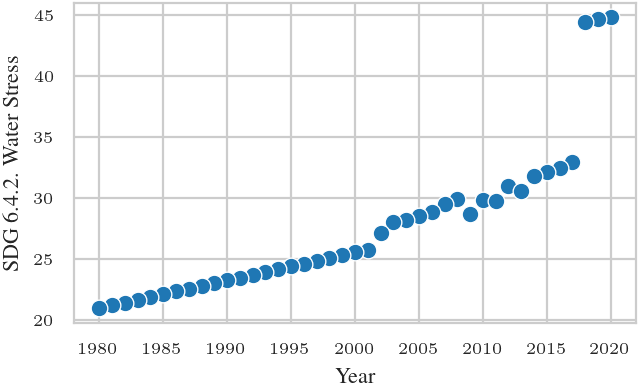

In [102]:
'''Just for testing'''
sns.scatterplot(data=stress_df[stress_df['Country'] == 'Mexico'], x='Year',
                y='SDG 6.4.2. Water Stress')
plt.show()

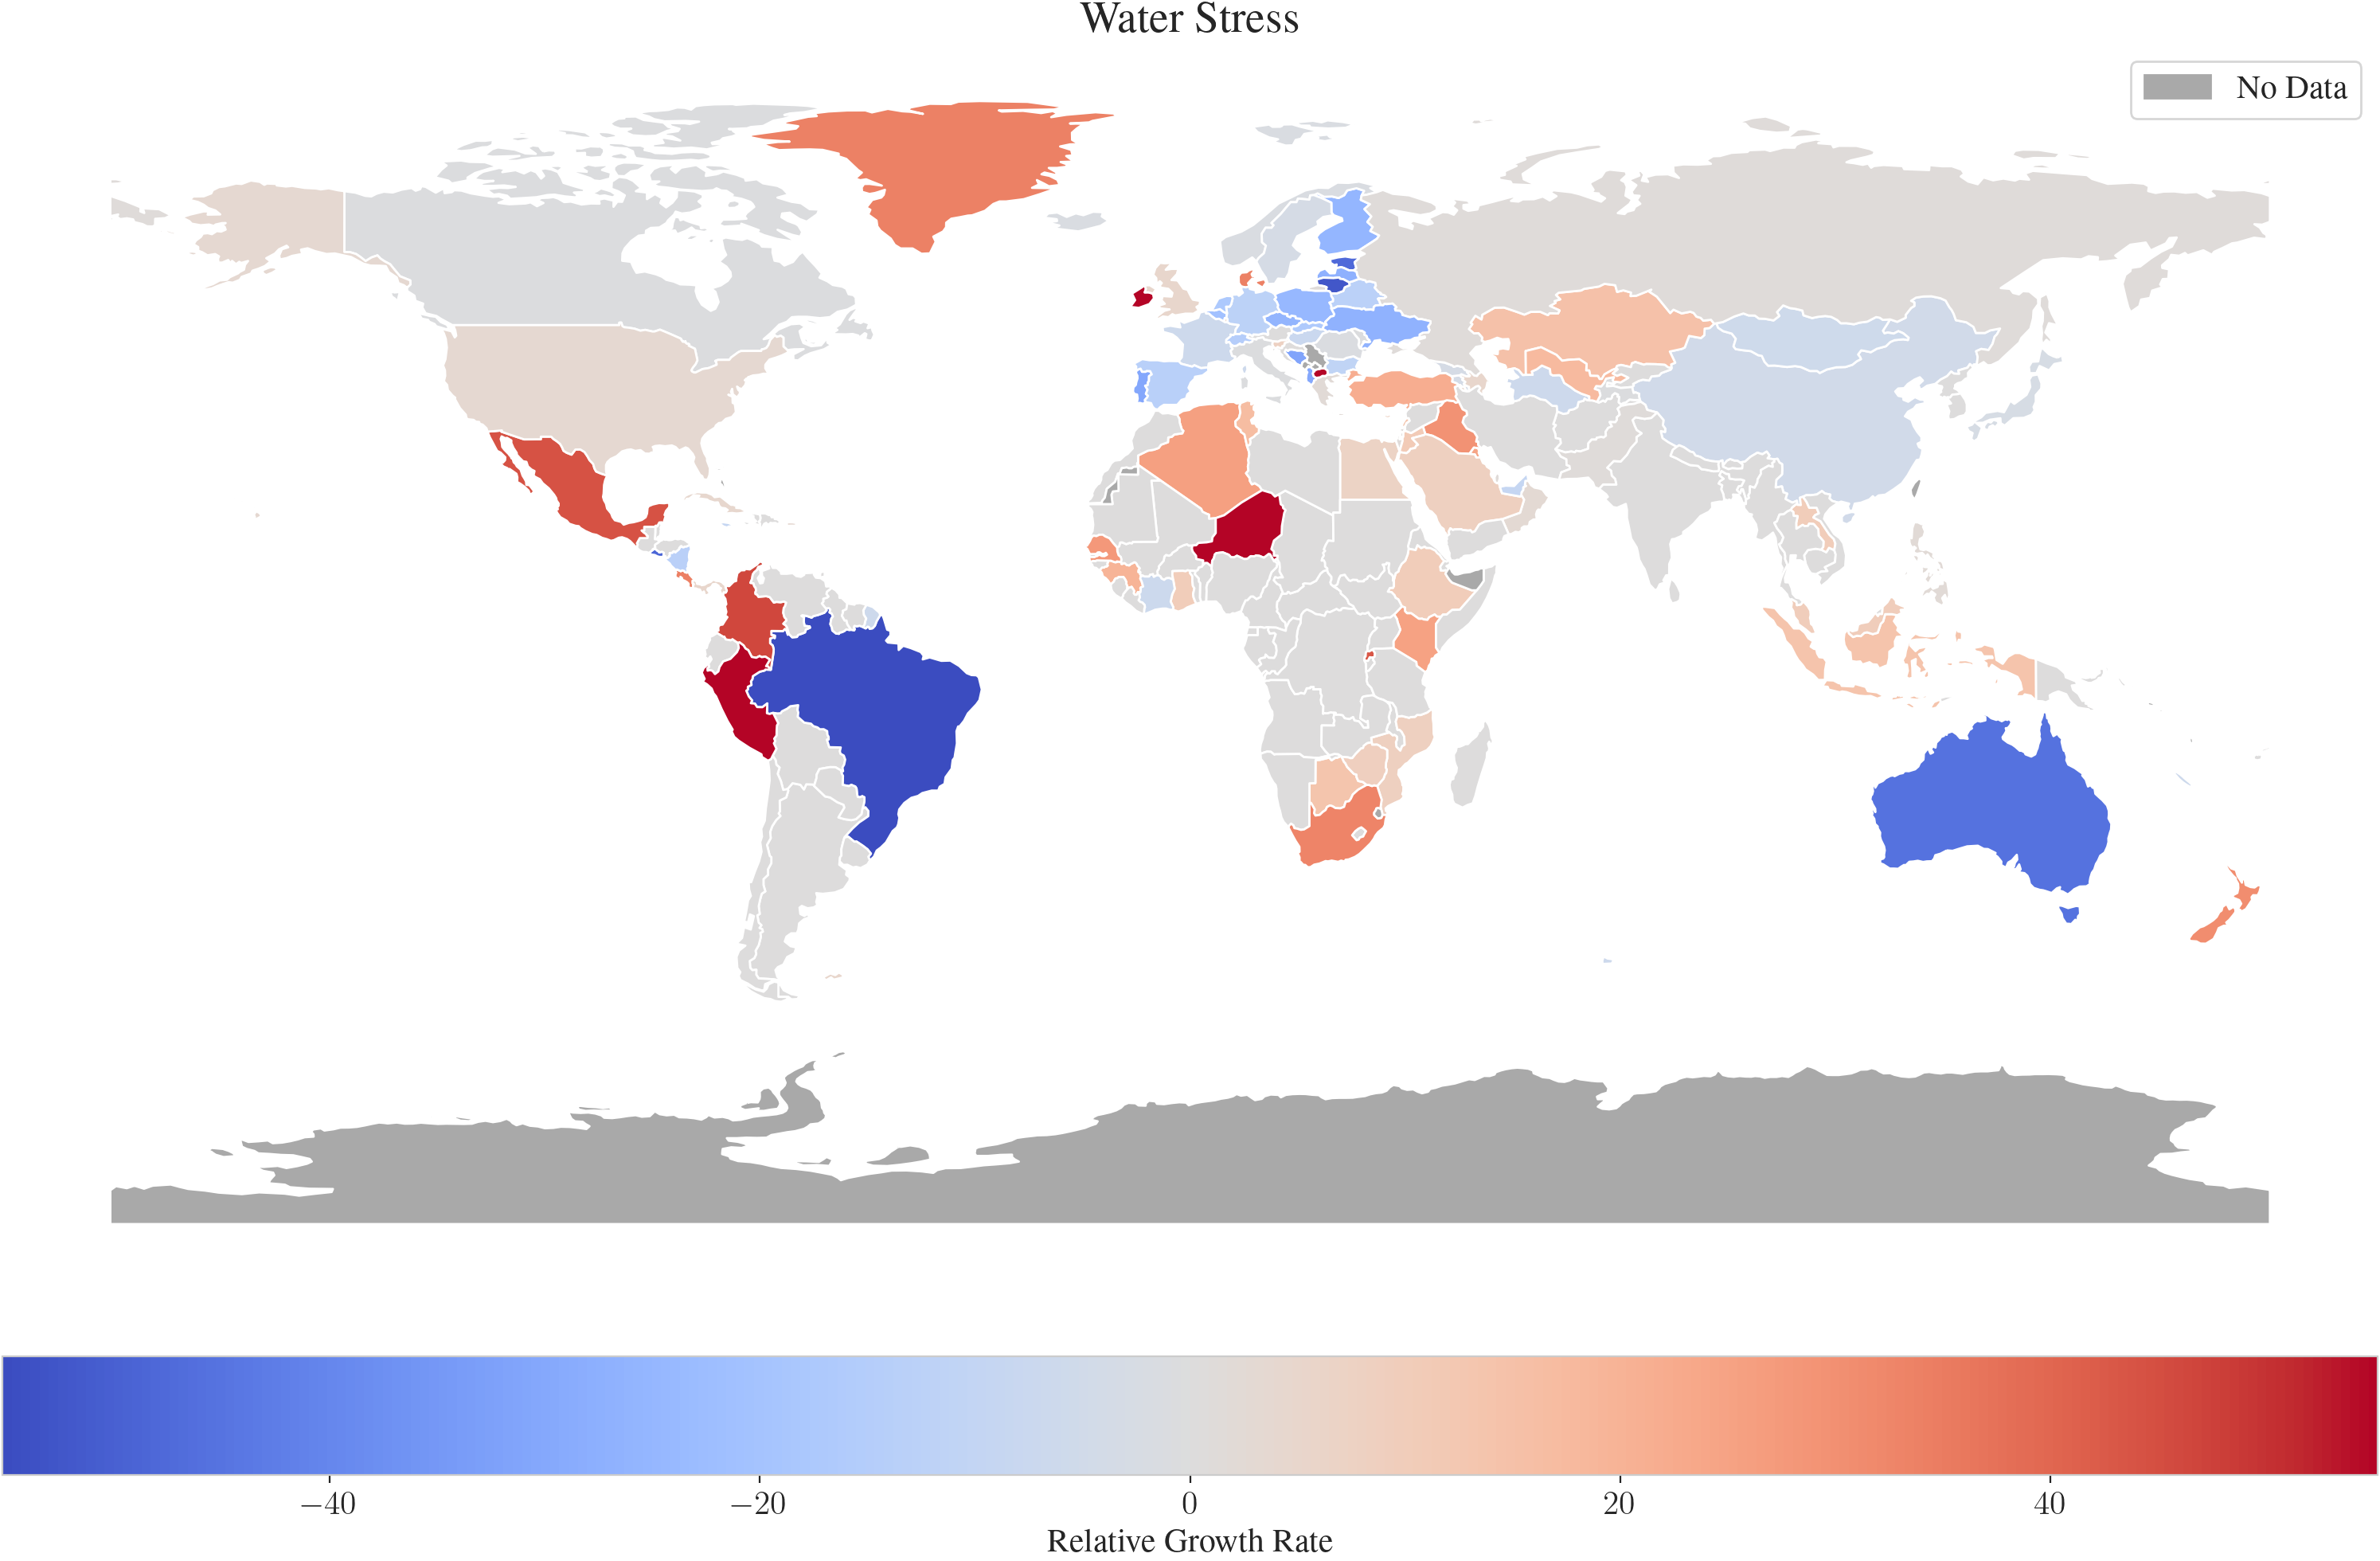

Saving figure to fig/water_management/fig_growth_rate_SDG_6.4.2._Water_Stress.pdf ... Done!


In [103]:
plot_growth_rates(
    stress_df,
    'SDG 6.4.2. Water Stress',
    'coolwarm',
    'Water Stress'
)


it could be also interesting to look how their wastewater output has changed.

In [104]:
# Create a new dataframe with only the columns we are interested in
interesting_var = 'Produced municipal wastewater'

wwater_df = aquastat_df[['Country', 'Year', interesting_var]]
wwater_df = wwater_df.dropna()  # Drop rows with missing values
wwater_df = wwater_df.sort_values(by=interesting_var, ascending=False)  # Sort by number of facilities

wwater_df

Variable,Country,Year,Produced municipal wastewater
2614,Denmark,2011,364.4770
2615,Denmark,2012,363.8300
2616,Denmark,2013,360.8530
2617,Denmark,2014,353.6670
10143,United States of America,2020,60.4100
...,...,...,...
6041,Mauritius,2016,0.0006
6043,Mauritius,2018,0.0006
6044,Mauritius,2019,0.0006
6045,Mauritius,2020,0.0006


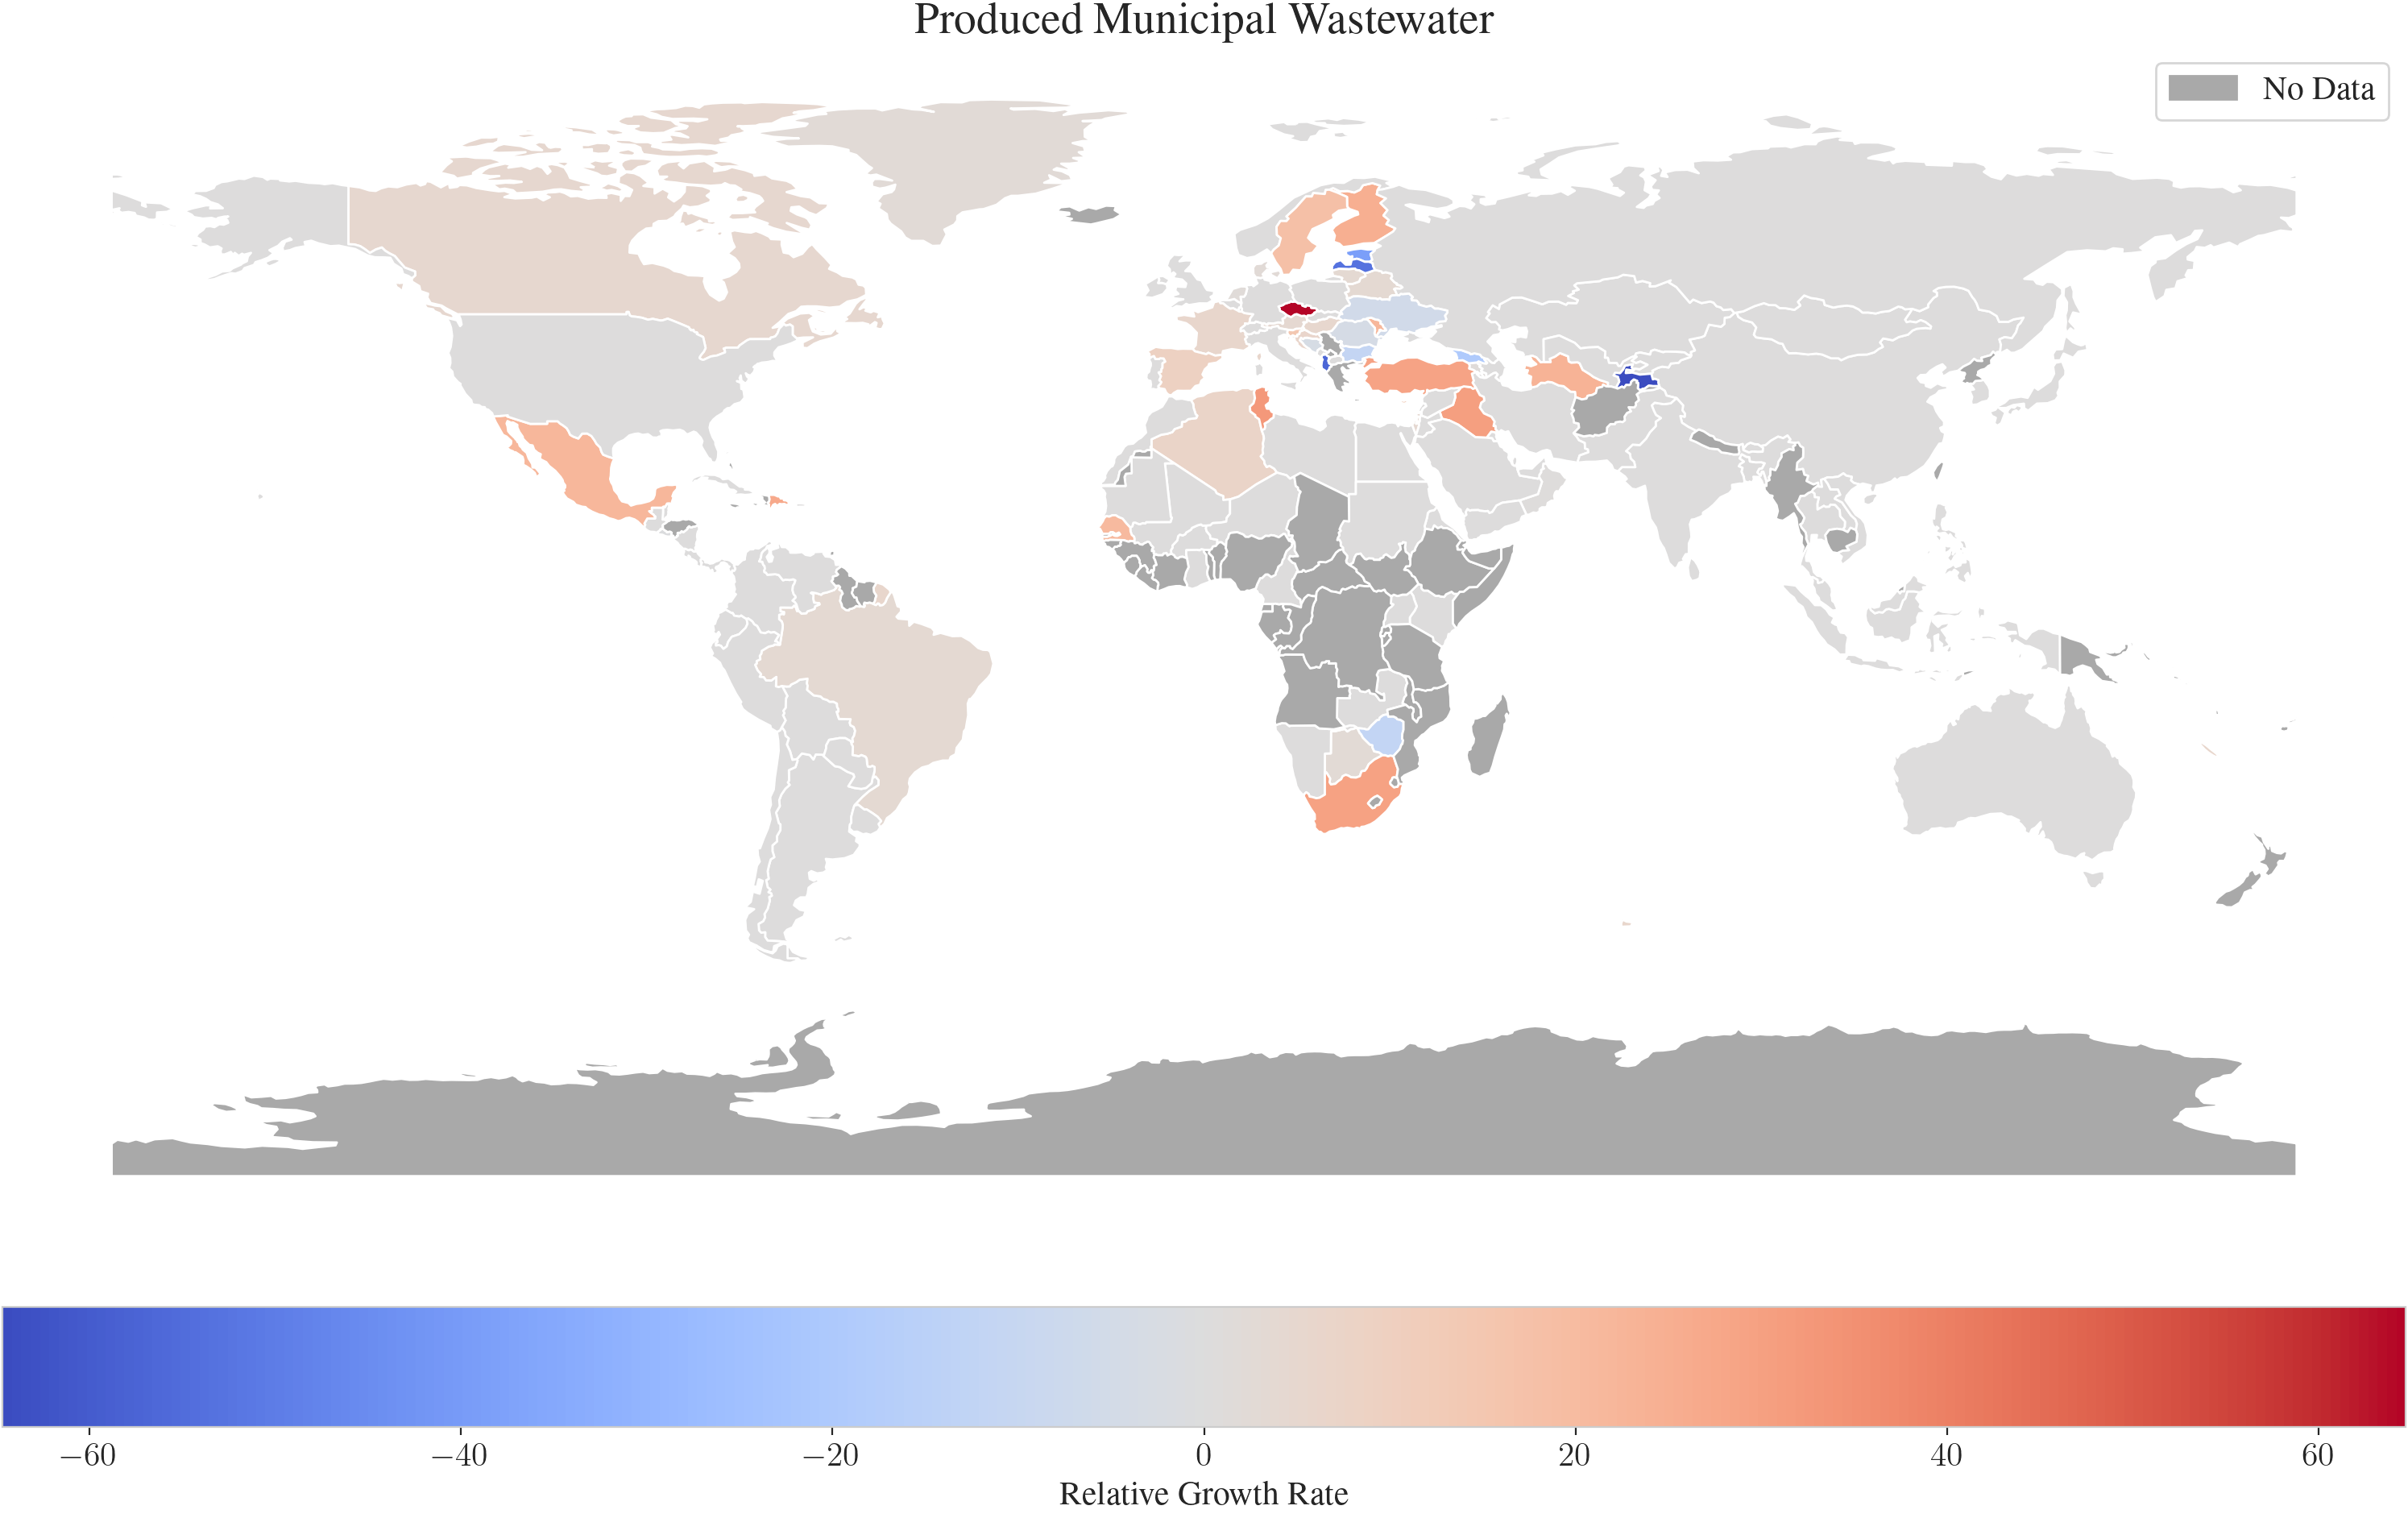

Saving figure to fig/water_management/fig_growth_rate_Produced_municipal_wastewater.pdf ... Done!


In [105]:
plot_growth_rates(
    wwater_df,
    interesting_var,
    'coolwarm',
    'Produced Municipal Wastewater'
)

What we see is that most countries don't face a change in produced waste water.

# TODOS

- Plot the development of the number of facilities over time
- Plot the number of facilities per capita
- [HydroWASTE](https://www.hydrosheds.org/products/hydrowaste):
    - Download the data
    - Explore the data:
        - A nice map of the world
        - The more facilities, the more water is treated?
            - Plot the number of facilities against the water withdrawal
            - What about the countries that face water scarcity?
                - Plot the number of facilities against the water scarcity: facility / water scarcity -> should be normalized by water stress (water scarcity / water availability)  